# US Car Accidents Analysis: Can Population numbers Explain Accident Counts?

This notebook explores whether basic simple predictors — population size and VMT (Vehicle Miles Traveled)  — can explain variability in car accident counts across U.S. states.


## Table of Contents

1. [Exploring the Kaggle Accident Dataset](#exploring-the-kaggle-accident-dataset)  
   - Overview of columns  
   - Sampling and inspecting key fields (e.g., Weather Condition, Comments)  
   - Removing duplicates  
   - Categorical column exploration with subplots

2. [Importing and Preparing Population Data](#importing-and-preparing-population-data)  
   - Extracting 2020 population counts  
   - State name normalization and filtering

3. [Importing and Preparing VMT Data](#importing-and-preparing-vmt-data)  
   - Extracting urban and rural VMT  
   - Creating rural-to-urban VMT ratio

4. [Exploratory Analysis](#exploratory-analysis)  
   - Relationships between VMT, population, and accident totals

5. [Linear Regression: log(Accidents) ~ log(Population)](#linear-regression-logaccidents--logpopulation)

6. [Linear Regression: log(Accidents) ~ log(Population) + VMT Ratio](#linear-regression-logaccidents--logpopulation--vmt-ratio)

7. [Summary and Interpretation](#summary-and-interpretation)



In [401]:
import statsmodels.api as sm
import plotly.express as px
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# exploring-the-kaggle-accident-dataset
To download the data, visit: https://www.kaggle.com/datasets/sobhanmoosavi/us-accidents/data

In [2]:
df = pd.read_csv('US_Accidents_March23.csv')

In [3]:
df.head()

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,...,False,False,False,False,True,False,Day,Day,Day,Day


In [5]:
#Null values proportion
(df.isnull().mean()*100).sort_values(ascending = False)

End_Lat                  44.029355
End_Lng                  44.029355
Precipitation(in)        28.512858
Wind_Chill(F)            25.865904
Wind_Speed(mph)           7.391355
Visibility(mi)            2.291524
Wind_Direction            2.267043
Humidity(%)               2.253301
Weather_Condition         2.244438
Temperature(F)            2.120143
Pressure(in)              1.820288
Weather_Timestamp         1.555666
Nautical_Twilight         0.300787
Civil_Twilight            0.300787
Sunrise_Sunset            0.300787
Astronomical_Twilight     0.300787
Airport_Code              0.292881
Street                    0.140637
Timezone                  0.101030
Zipcode                   0.024779
City                      0.003274
Description               0.000065
Traffic_Signal            0.000000
Roundabout                0.000000
Station                   0.000000
Stop                      0.000000
Traffic_Calming           0.000000
Country                   0.000000
Turning_Loop        

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7728394 entries, 0 to 7728393
Data columns (total 46 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   ID                     object 
 1   Source                 object 
 2   Severity               int64  
 3   Start_Time             object 
 4   End_Time               object 
 5   Start_Lat              float64
 6   Start_Lng              float64
 7   End_Lat                float64
 8   End_Lng                float64
 9   Distance(mi)           float64
 10  Description            object 
 11  Street                 object 
 12  City                   object 
 13  County                 object 
 14  State                  object 
 15  Zipcode                object 
 16  Country                object 
 17  Timezone               object 
 18  Airport_Code           object 
 19  Weather_Timestamp      object 
 20  Temperature(F)         float64
 21  Wind_Chill(F)          float64
 22  Humidity(%)       

In [391]:
#Exploring the weather condition column. Won't be used in the analysis below.
df['Weather_Condition'].sample(10)

1773952           Cloudy
3040080    Partly Cloudy
565946              Fair
1551010             Fair
6360797           Cloudy
2486667    Mostly Cloudy
4078968    Partly Cloudy
2270461       Light Snow
41131              Clear
2299127         Overcast
Name: Weather_Condition, dtype: object

In [392]:
#Checking the meaning of the description column. 
#Won't be used in the current analysis.
pd.set_option('display.max_colwidth', None)
print(df[df['Severity']==3]['Description'].sample(10))
pd.reset_option('display.max_colwidth')

183621              Left hand shoulder blocked due to accident on I-75 Southbound after Exits 51B 51C I-375.
1432409         Right hand shoulder blocked due to accident on I-64 Hampton Roads Bltwy Westbound at MM 282.
2829861                                 Accident on I-26 Eastbound at Exits 209A 209B-A Ashley Phosphate Rd.
2012616       Accident on I-95 Southbound from Exit 132 SC-527 Black River Rd to Exit 122 US-521 Sumter Hwy.
3372557    Right lane blocked and right hand shoulder blocked due to accident on I-696 Eastbound after M-10.
926772                                      Lane blocked due to accident on I-30 Eastbound at Jim Miller Rd.
1571693                     Center lane blocked due to accident on I-88 Eastbound near Exit 125 Winfield Rd.
1065655                                      Accident on entry ramp to I-278 Westbound from I-495 Westbound.
441034                                                             Accident on I-710 Northbound after I-105.
2792039            

In [129]:
#Cleaning the Start_Time and End_Time columns to identify duplicates. 
#Times of accidents won't be used in this analysis.
df['Start_Time'] = df['Start_Time'].astype(str).str.replace(r'\.0+$', '', regex=True)
df['Start_Time']=pd.to_datetime(start_time,errors='coerce')
print(df['Start_Time'].isna().sum())
df['End_Time'] = df['End_Time'].astype(str).str.replace(r'\.0+$', '', regex=True)
df['End_Time']=pd.to_datetime(start_time,errors='coerce')
print(df['End_Time'].isna().sum())

0
0


In [135]:
#There are duplicates in the data, and the following cleans them out
df= df.drop_duplicates(subset=['Start_Time', 'End_Time'], keep='first')

In [393]:
print(f"The number of records in the cleaned data is {len(df)}")

The number of records in the cleaned data is 5801064


In [137]:
cat_columns = df.select_dtypes(include=[bool]).columns.tolist()
print(cat_columns)

['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop']


For the description of each of the precise description of the above categories, visit: https://arxiv.org/pdf/1906.05409

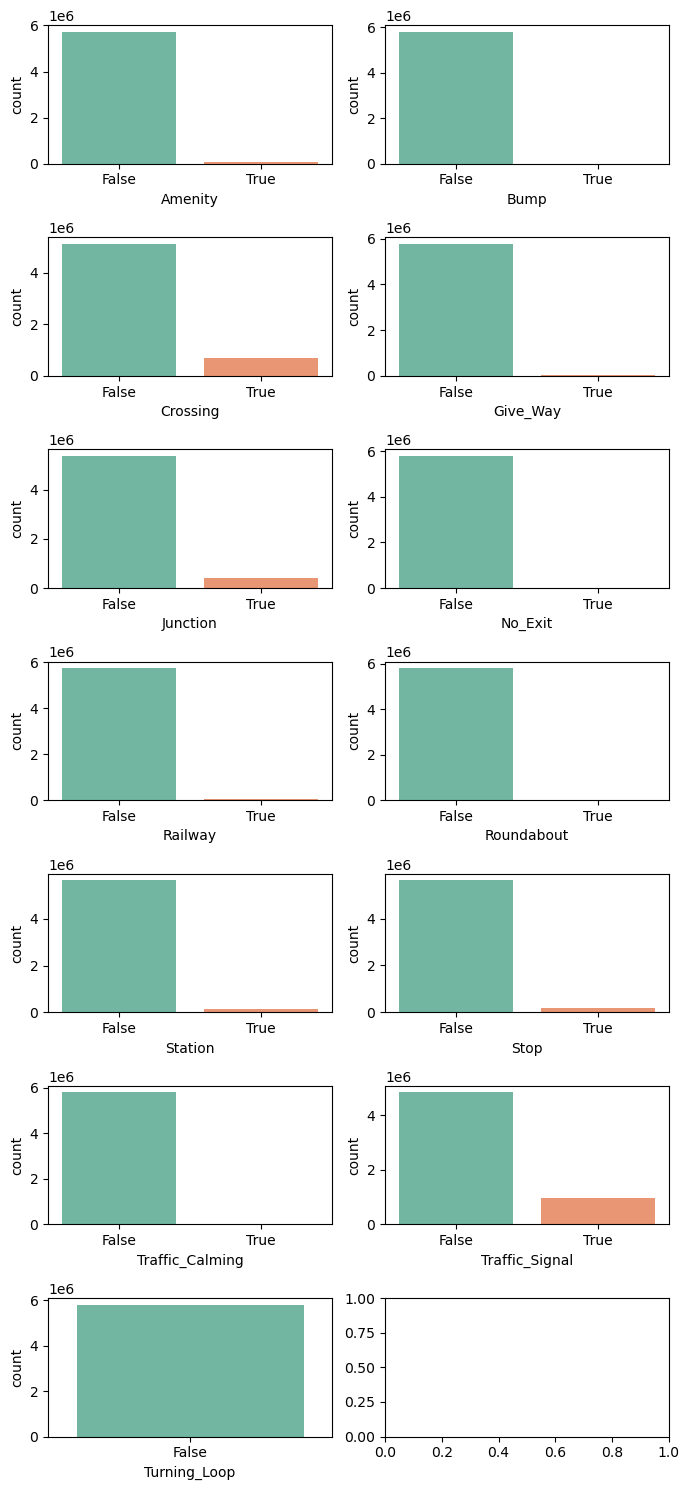

In [138]:
fig, axes = plt.subplots(7,2,figsize=(7,15))
axes=axes.flatten()


for i, col in enumerate(cat_columns):
    sns.countplot(data=df, x=col, palette='Set2', ax=axes[i])
    #axes[i].set_title(f'Counts for {col}')
    axes[i].set_xlabel(col)
    #axes[i].set_ylabel('Number of accidents')

# Adjust layout

plt.tight_layout()

Most categories were rarely marked as present near accidents and are unlikely to contribute meaningfully to the analysis. The only features with a significant count of `True` values are **Crossing**, **Junction**, and **Traffic Signal**.

Based on definitions from [this source](https://arxiv.org/pdf/1906.05409):

- **Crossing**: Any pedestrian or cyclist crossing — likely more common in urban areas.  
- **Junction**: Includes highway ramps, exits, and entrances — likely prevalent in rural settings as well.


In [395]:
print(f"The total number of records of accidents in data is {len(df)}\n")

print(f"Accidents in presence of a traffic signal is {100 * df['Traffic_Signal'].sum() / len(df):.2f}% of total.\n")

print(f"Accidents in presence of a crossing is {100 * df['Crossing'].sum() / len(df):.2f}% of total.")

print(f"Accidents in presence of a junction is {100 * df['Junction'].sum() / len(df):.2f}% of total.")


print(f"Accidents in presence of a crossing and traffic signal is "
      f"{100 * (df['Crossing'] & df['Traffic_Signal']).sum() / df['Crossing'].sum():.2f}% of total number of crossing accidents")

print(f"Accidents in presence of a junction and traffic signal is "
      f"{100 * (df['Junction'] & df['Traffic_Signal']).sum() / df['Junction'].sum():.2f}% of the junction accidents")

# print(f"Accidents of severity 3 in presence of a crossing and traffic signal is "
#       f"{100 * (df[df['Severity'] == 3]['Crossing'] & df[df['Severity'] == 3]['Traffic_Signal']).sum() / df[df['Severity'] == 3]['Crossing'].sum():.2f}% "
#       f"of total number of\n crossing accidents of severity 3\n")

# print(f"Accidents of severity 4 in presence of a crossing and traffic signal is "
#       f"{100 * (df[df['Severity'] == 4]['Crossing'] & df[df['Severity'] == 4]['Traffic_Signal']).sum() / df[df['Severity'] == 4]['Crossing'].sum():.2f}% "
#       f"of total number of\n crossing accidents of severity 4\n")




# print(f"Accidents of severity 3 in presence of a crossing and traffic signal is "
#       f"{100 * (df[df['Severity'] == 3]['Crossing'] & df[df['Severity'] == 3]['Traffic_Signal']).sum() / df[df['Severity'] == 3]['Crossing'].sum():.2f}% "
#       f"of total number of\n crossing accidents of severity 3\n")

# print(f"Accidents of severity 4 in presence of a crossing and traffic signal is "
#       f"{100 * (df[df['Severity'] == 4]['Crossing'] & df[df['Severity'] == 4]['Traffic_Signal']).sum() / df[df['Severity'] == 4]['Crossing'].sum():.2f}% "
#       f"of total number of\n crossing accidents of severity 4\n")

The total number of records of accidents in data is 5801064

Accidents in presence of a traffic signal is 16.52% of total.

Accidents in presence of a crossing is 11.77% of total.
Accidents in presence of a junction is 7.33% of total.
Accidents in presence of a crossing and traffic signal is 66.62% of total number of crossing accidents
Accidents in presence of a junction and traffic signal is 1.77% of the junction accidents


### Summary: Infrastructure Elements in Accident Records

Out of a total of **5,801,064 accident records**:

- **16.52%** occurred in the presence of a **traffic signal**
- **11.77%** involved a **crossing**
- **7.33%** occurred near a **junction**

Among these:

- **66.62%** of crossing-related accidents also had a **traffic signal**
- Only **1.77%** of junction-related accidents involved a **traffic signal**

### Interpretation

Crossings are often paired with traffic signals, likely reflecting their prevalence in **urban, pedestrian-heavy environments**. In contrast, junctions appear less frequently and are **rarely accompanied by traffic signals**, suggesting that they may be more common in **rural or highway settings** where signal control is limited. This distinction may influence the nature and severity of accidents occurring in these different environments.


Text(0.5, 1.0, 'Accident severity count')

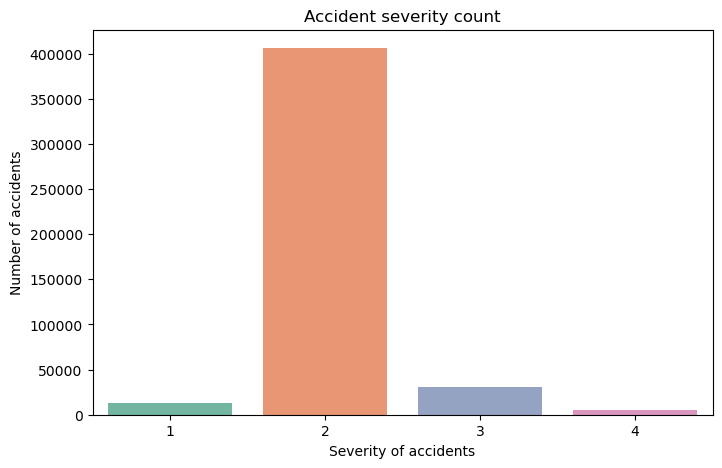

In [140]:
plt.figure(figsize=(8,5))
sns.countplot(data=df[df['Traffic_Signal']&df['Crossing']], x='Severity', palette='Set2')
plt.xlabel('Severity of accidents')
plt.ylabel('Number of accidents')
plt.title('Accident severity count')


In [398]:
print(f"Accidents of severity > 2 in presence of a crossing is "
       f"{100 * (df[df['Severity'] >= 3]['Crossing']).sum() / len(df[df['Severity'] >= 3]):.2f}% "
       f"of total number of accidents of severity greater than 2\n")

print(f"Accidents of severity > 2 in presence of a Junction is "
       f"{100 * (df[df['Severity'] >= 3]['Junction']).sum() / len(df[df['Severity'] >= 3]):.2f}% "
       f"of total number of accidents of severity greater than 2\n")

Accidents of severity greater than 2 in presence of a crossing is 3.81% of total number of accidents of severity greater than 2

Accidents of severity greater than 2 in presence of a Junction is 10.22% of total number of accidents of severity greater than 2



### Interpretation: Severe Accidents Near Crossings and Junctions

Among all accidents of **severity greater than 2**:

- Only **3.81%** occurred near a **crossing**
- A larger **10.22%** occurred near a **junction**

These findings suggest that **severe accidents are more likely to occur near junctions than crossings**. This may reflect the higher complexity of vehicle movements at junctions — such as merging, turning, or navigating ramps — often at higher speeds and with less pedestrian infrastructure. In contrast, crossings are more common in urban environments with lower speeds and better signalization, potentially reducing the severity of incidents when they do occur.

---

### Visualizing Categorical Accident Factors by Severity Level

The following plot offers additional context by summarizing the number of accidents involving key categorical features (e.g., **Junction**, **Crossing**, **Traffic_Signal**, etc.) across severity levels 1 through 4. While this visualization is not used directly in the final analysis, it provides a broader view of how these conditions vary with accident severity.

- The dataset is grouped by `Severity`, and the total counts of each categorical feature are summed.
- A **bar plot** is generated for each severity level, showing how frequently each feature was present.
- The result is a **4-row subplot** (one per severity level), enabling comparison of patterns across severity levels.

This visualization may help highlight whether certain traffic features are more frequently associated with higher-severity accidents.


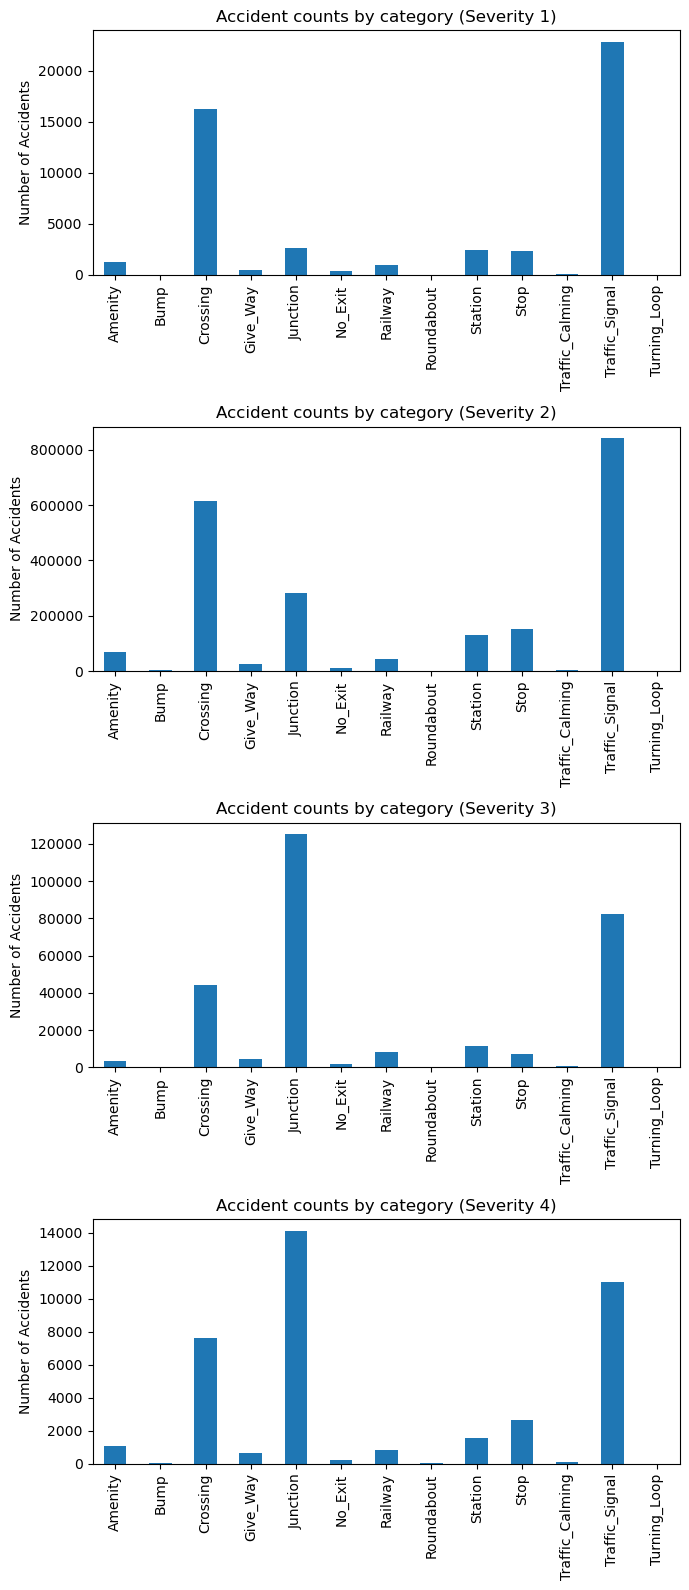

In [141]:
severity_counts = df.groupby('Severity')[cat_columns].sum()

fig, axes = plt.subplots(4,1,figsize=(7,16))
axes=axes.flatten()

for i in range(4):
    severity = i+1
    counts_series = severity_counts.loc[severity]
    counts_series.plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'Accident counts by category (Severity {severity})')
    #axes[i].set_xlabel('Category')
    axes[i].set_ylabel('Number of Accidents')

plt.tight_layout()


# importing-and-preparing-population-data

The table below presents U.S. national population totals from 2020 to 2024, sourced from the U.S. Census Bureau. For this analysis, only the data from the year **2020** will be used.  
Source: [U.S. Census Population Estimates (2020s)](https://www.census.gov/data/tables/time-series/demo/popest/2020s-national-total.html)


In [91]:
pop_df_to_filter = pd.read_excel('NST-EST2024-POP.xlsx')

In [400]:
pop_df_to_filter.head(9)

,table with row headers in column A and column headers in rows 3 through 4. (leading dots indicate sub-parts),Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,Annual Estimates of the Resident Population fo...,NaN,NaN,NaN,NaN,NaN,NaN
1,Geographic Area,"April 1, 2020 Estimates Base",Population Estimate (as of July 1),NaN,NaN,NaN,NaN
2,NaN,NaN,2020,2021.0,2022.0,2023.0,2024.0
3,United States,331515736,331577720,332099760.0,334017321.0,336806231.0,340110988.0
4,Northeast,57617706,57431458,57252533.0,57159597.0,57398303.0,57832935.0
5,Midwest,68998970,68984258,68872831.0,68903297.0,69186401.0,69596584.0
6,South,126281537,126476549,127368010.0,129037849.0,130893358.0,132665693.0
7,West,78617523,78685455,78606386.0,78916578.0,79328169.0,80015776.0
8,.Alabama,5025369,5033094,5049196.0,5076181.0,5117673.0,5157699.0


The table displays full state names. For merging purposes, we will convert them to their corresponding **two-letter abbreviations**.
 

In [97]:
pop_df=pop_df_to_filter.loc[8:,['table with row headers in column A and column headers in rows 3 through 4. (leading dots indicate sub-parts)','Unnamed: 1']].copy()
pop_df.columns = ['State', 'Population count']
state_abbrev = {
    'ALABAMA': 'AL', 'ALASKA': 'AK', 'ARIZONA': 'AZ', 'ARKANSAS': 'AR', 'CALIFORNIA': 'CA',
    'COLORADO': 'CO', 'CONNECTICUT': 'CT', 'DELAWARE': 'DE', 'DISTRICT OF COLUMBIA': 'DC',
    'FLORIDA': 'FL', 'GEORGIA': 'GA', 'HAWAII': 'HI', 'IDAHO': 'ID', 'ILLINOIS': 'IL',
    'INDIANA': 'IN', 'IOWA': 'IA', 'KANSAS': 'KS', 'KENTUCKY': 'KY', 'LOUISIANA': 'LA',
    'MAINE': 'ME', 'MARYLAND': 'MD', 'MASSACHUSETTS': 'MA', 'MICHIGAN': 'MI', 'MINNESOTA': 'MN',
    'MISSISSIPPI': 'MS', 'MISSOURI': 'MO', 'MONTANA': 'MT', 'NEBRASKA': 'NE', 'NEVADA': 'NV',
    'NEW HAMPSHIRE': 'NH', 'NEW JERSEY': 'NJ', 'NEW MEXICO': 'NM', 'NEW YORK': 'NY',
    'NORTH CAROLINA': 'NC', 'NORTH DAKOTA': 'ND', 'OHIO': 'OH', 'OKLAHOMA': 'OK', 'OREGON': 'OR',
    'PENNSYLVANIA': 'PA', 'RHODE ISLAND': 'RI', 'SOUTH CAROLINA': 'SC', 'SOUTH DAKOTA': 'SD',
    'TENNESSEE': 'TN', 'TEXAS': 'TX', 'UTAH': 'UT', 'VERMONT': 'VT', 'VIRGINIA': 'VA',
    'WASHINGTON': 'WA', 'WEST VIRGINIA': 'WV', 'WISCONSIN': 'WI', 'WYOMING': 'WY',
    'PUERTO RICO': 'PR'
}
pop_df['State abbreviated']=pop_df['State'].str.strip().str.strip('.').str.upper().apply(lambda x: state_abbrev[x] if x in state_abbrev else x)

pop_df.head()



,State,Population count,State abbreviated
8,.Alabama,5025369,AL
9,.Alaska,733395,AK
10,.Arizona,7158110,AZ
11,.Arkansas,3011553,AR
12,.California,39555674,CA


In [98]:
pop_df['State abbreviated'].unique()

array(['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'DC', 'FL', 'GA',
       'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA',
       'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY',
       'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
       'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY', nan, 'PR',
       'THE CENSUS BUREAU HAS REVIEWED THIS DATA PRODUCT TO ENSURE APPROPRIATE ACCESS, USE, AND DISCLOSURE AVOIDANCE PROTECTION OF THE CONFIDENTIAL SOURCE DATA USED TO PRODUCE THIS PRODUCT (DATA MANAGEMENT SYSTEM (DMS) NUMBER:\xa0 P-6000042 AND P-7501659. DISCLOSURE REVIEW BOARD (DRB) APPROVAL NUMBER:\xa0CBDRB-FY25-0078)',
       'NOTE: THE ESTIMATES ARE DEVELOPED FROM A BASE THAT INTEGRATES THE 2020 CENSUS, VINTAGE 2020 ESTIMATES, AND (FOR THE U.S. ONLY) 2020 DEMOGRAPHIC ANALYSIS ESTIMATES.  FOR POPULATION ESTIMATES METHODOLOGY STATEMENTS, SEE HTTPS://WWW.CENSUS.GOV/PROGRAMS-SURVEYS/POPEST/TECHNICAL-DOCUMENTATION/METHODOLOGY.HTML. SEE GEOG

In [99]:
AccDfStates=df['State'].unique()
pop_df=pop_df[pop_df['State abbreviated'].isin(AccDfStates)].copy()
pop_df=pop_df.reset_index(drop=True)
#pop_df.index=pop_df.index+1
pop_df['State']=pop_df['State abbreviated'].copy()
pop_df.drop('State abbreviated',axis=1,inplace=True)
pop_df['Population count']=pd.to_numeric(pop_df['Population count'])
pop_df.head()

,State,Population count
0,AL,5025369
1,AZ,7158110
2,AR,3011553
3,CA,39555674
4,CO,5775324


# importing-and-preparing-vmt-data

We now import the **2022 Vehicle Miles Traveled (VMT)** data from the Federal Highway Administration (FHWA), available at:  
[https://www.fhwa.dot.gov/policyinformation/statistics/2022/vm2.cfm](https://www.fhwa.dot.gov/policyinformation/statistics/2022/vm2.cfm)

VMT represents the total number of miles driven by vehicles on public roads within a given region and is a key measure of transportation activity. This data is collected by state and local transportation agencies through roadway sensors, traffic counters, and administrative records.

For this analysis, we extract **VMT for rural and urban roadways** by state and compute the ratio **$\frac{\text{VMT_Rural}}{\text{VMT_Urban}}$**. This ratio serves as a proxy for the **predominant driving environment** in each state, helping us assess whether rural-dominant states experience different accident patterns compared to urban-dominant ones.



In [346]:
url = "https://www.fhwa.dot.gov/policyinformation/statistics/2022/vm2.cfm"
VMT=pd.read_html(url)
VMT=VMT[0][[('STATE','STATE'),('RURAL','TOTAL'),('URBAN','TOTAL'),('TOTAL','TOTAL')]].copy()
VMT.columns = ['State','VMT rural', 'VMT urban' ,'Total VMT']

VMT['State']=VMT['State'].str.strip().str.strip('.').str.upper().apply(lambda x: state_abbrev[x] if x in state_abbrev else x)
VMT = VMT[VMT['State'].isin(df['State'])].copy()
VMT.head(10)
VMT[['VMT rural', 'VMT urban' ,'Total VMT']]=VMT[['VMT rural', 'VMT urban', 'Total VMT']].apply(pd.to_numeric, errors='coerce').fillna(0)
VMT['VMT rural per urban']=VMT['VMT rural']/VMT['VMT urban']
VMT.head()


,State,VMT rural,VMT urban,Total VMT,VMT rural per urban
0,AL,29141.0,42490,71631,0.685832
2,AZ,17900.0,58259,76159,0.307249
3,AR,18489.0,20042,38530,0.922513
4,CA,60267.0,254977,315244,0.236362
5,CO,16814.0,37121,53935,0.452951


# exploratory-analysis   
   

In this section, we aggregate accident data at the state level and join it with population and VMT data. We also compute several derived metrics such as:

- Accidents per capita
- Accidents near junctions per total VMT
- Frequency of accidents at crossings and with traffic signals

These summaries provide a broader understanding of how population, infrastructure, and driving exposure relate to accident counts across states.


In [349]:
Acc_and_pop_counts=pop_df.copy()

In [350]:
#Adding counts of total num of accidents in states
Acc_and_pop_counts=Acc_and_pop_counts.merge(df['State'].value_counts().rename('Acc tot').reset_index(),on='State',how='left')
#adding counts of Accidents in presence of Crossing and Traffic_signal
Acc_and_pop_counts=Acc_and_pop_counts.merge(df[(df['Crossing'])]['State'].value_counts().rename('Acc near crossing').reset_index(),on='State',how='left')
#adding counts of Accidents in presence of Crossing and Traffic_signal
Acc_and_pop_counts=Acc_and_pop_counts.merge(df[(df['Traffic_Signal'])&(df['Crossing'])]['State'].value_counts().rename('Acc near crossing with traffic signal').reset_index(),on='State',how='left')
#adding counts of Accidents in presence of Junction
Acc_and_pop_counts=Acc_and_pop_counts.merge(df[df['Junction']]['State'].value_counts().rename('Acc near junction').reset_index(),on='State',how='left')
#adding VMT
Acc_and_pop_counts=Acc_and_pop_counts.merge(VMT,on='State',how='left')
Acc_and_pop_counts['VMT per capita']=Acc_and_pop_counts['Total VMT']/Acc_and_pop_counts['Population count']
Acc_and_pop_counts["Acc per capita"] = Acc_and_pop_counts["Acc tot"]/Acc_and_pop_counts["Population count"]
Acc_and_pop_counts['Acc near junction per VMT'] = Acc_and_pop_counts['Acc near junction']/Acc_and_pop_counts['Total VMT']
Acc_and_pop_counts[['log Population count','log Acc tot',' log Total VMT']] = np.log(Acc_and_pop_counts[['Population count','Acc tot','Total VMT']])
Acc_and_pop_counts.head()

,State,Population count,Acc tot,Acc near crossing,Acc near crossing with traffic signal,Acc near junction,VMT rural,VMT urban,Total VMT,VMT rural per urban,VMT per capita,Acc per capita,Acc near junction per VMT
0,AL,5025369,89766,1874,1338,3670,29141.0,42490,71631,0.685832,0.014254,0.017863,0.051235
1,AZ,7158110,128557,46646,37212,4291,17900.0,58259,76159,0.307249,0.010640,0.017960,0.056343
2,AR,3011553,14712,794,172,1442,18489.0,20042,38530,0.922513,0.012794,0.004885,0.037425
3,CA,39555674,1193458,63020,37147,136472,60267.0,254977,315244,0.236362,0.007970,0.030172,0.432909
4,CO,5775324,69317,12850,9952,4025,16814.0,37121,53935,0.452951,0.009339,0.012002,0.074627


## Exploring the relationship of accident, population and VMT numbers
The following section explores the relationship between accident counts, population, and VMT across states. Since each of these variables appears to vary exponentially by state, we apply a **log-log transformation** and perform **linear regression analysis** on the transformed data.

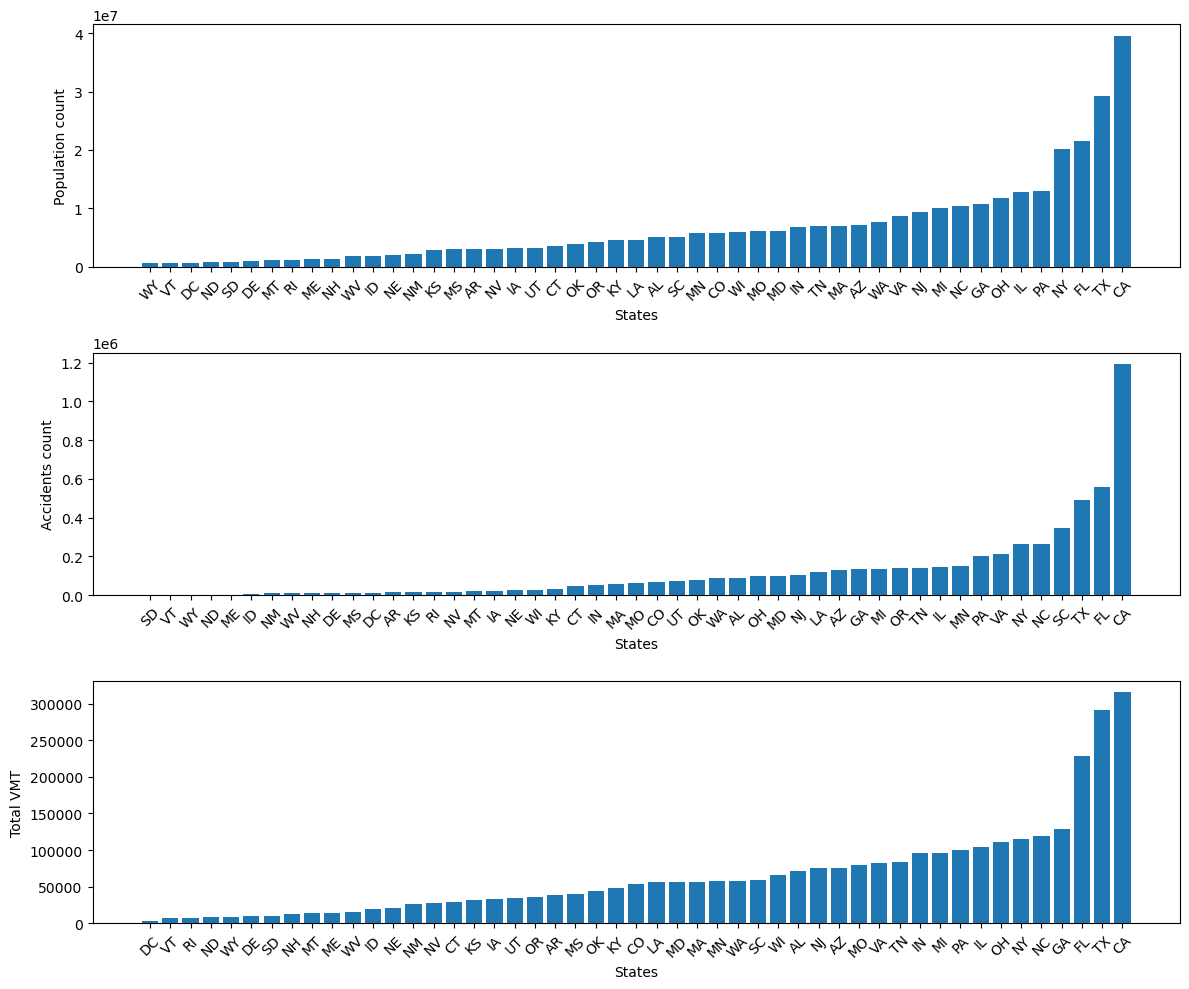

In [221]:
pop_sorted = Acc_and_pop_counts[['State','Population count']].sort_values('Population count')
Acc_sorted = Acc_and_pop_counts[['State','Acc tot']].sort_values('Acc tot')
Tot_VMT_sorted = Acc_and_pop_counts[['State','Total VMT']].sort_values('Total VMT')

fig , Axes = plt.subplots(3,1,figsize=(12,10))
Axes[0].bar(pop_sorted['State'],pop_sorted['Population count'])
Axes[0].set_xlabel('States')
Axes[0].set_ylabel('Population count')
Axes[0].tick_params(axis='x', rotation=45)

Axes[1].bar(Acc_sorted['State'],Acc_sorted['Acc tot'])
Axes[1].set_xlabel('States')
Axes[1].set_ylabel('Accidents count')
Axes[1].tick_params(axis='x', rotation=45)

Axes[2].bar(Tot_VMT_sorted['State'],Tot_VMT_sorted['Total VMT'])
Axes[2].set_xlabel('States')
Axes[2].set_ylabel('Total VMT')
Axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()

- As mentioned above, the bar plot of population, accident and VMT counts exhibits exponential growth across states. This motivates to consider log-log scatter plot to better capture and compare these relationships.

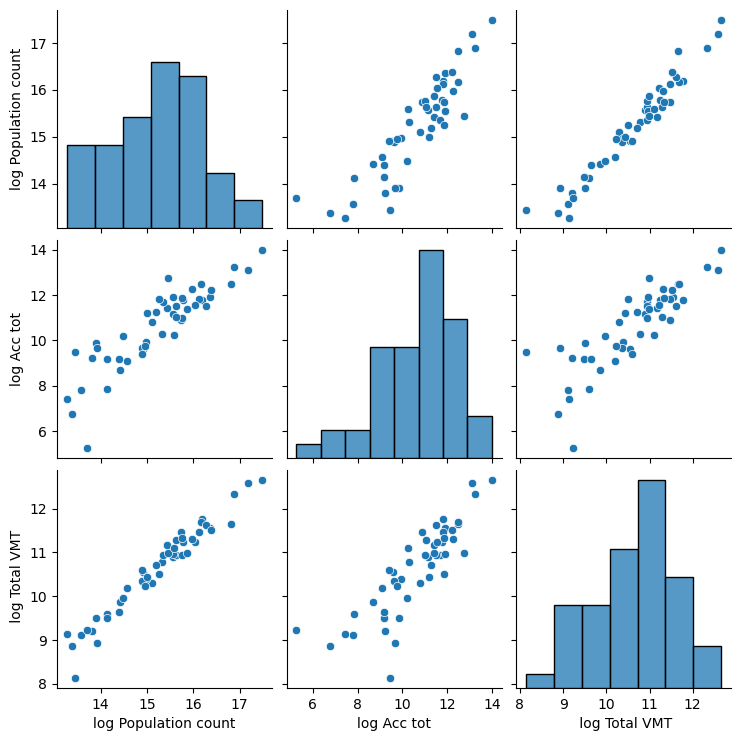

In [405]:
sns.pairplot(Acc_and_pop_counts[['log Population count','log Acc tot',' log Total VMT']])

## Collinearity of Population and VMT

The pair plot above indicates that **population** and **VMT** are highly collinear across states. Given this strong linear relationship, including both as predictors in the same model would introduce redundancy and potential multicollinearity issues. Therefore, to maintain interpretability and simplicity, **only population** is used as a predictor for accident counts in the regression analysis.


# linear-regression-logaccidents--logpopulation




In [447]:
X=Acc_and_pop_counts['log Population count']
y=Acc_and_pop_counts['log Acc tot']
X_const=sm.add_constant(X)
PopVsAcc=sm.OLS(y,X_const).fit()
y_pred=PopVsAcc.predict(X_const)

Text(0, 0.5, 'log(Accidents)')

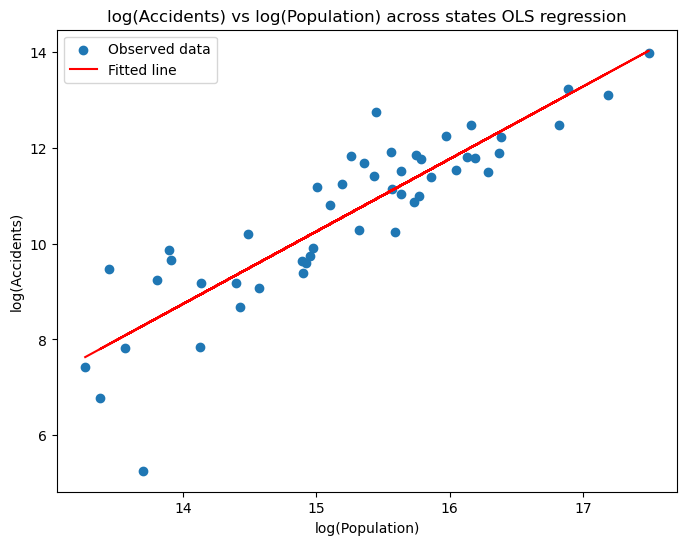

In [449]:

plt.figure(figsize=(8,6))
plt.scatter(X,y,label='Observed data')
plt.plot(X,y_pred,color='red',label='Fitted line')
plt.title('log(Accidents) vs log(Population) across states OLS regression')
plt.legend()
plt.xlabel('log(Population)')
plt.ylabel('log(Accidents)')


## Outlier analysis
The plot above reveals a significant outlier, which corresponds to **South Dakota**.  
Below, I present the regression results including this outlier. In the next step, I will manually exclude it and demonstrate that doing so leads to a substantial improvement in the model fit.


### Residuals analysis 
Recall that a key assumption of linear regression is that the residuals are approximately normally distributed, which is essential for valid statistical inference.  
In the analysis below, we show that the residuals from the model **including the outlier** (South Dakota) yield a **high p-value** in the **Shapiro–Wilk test**, indicating that normality cannot be confidently assumed.  
However, after removing the outlier, the **p-value decreases sufficiently**, suggesting that the residuals more closely follow a normal distribution.


<Figure size 800x600 with 0 Axes>

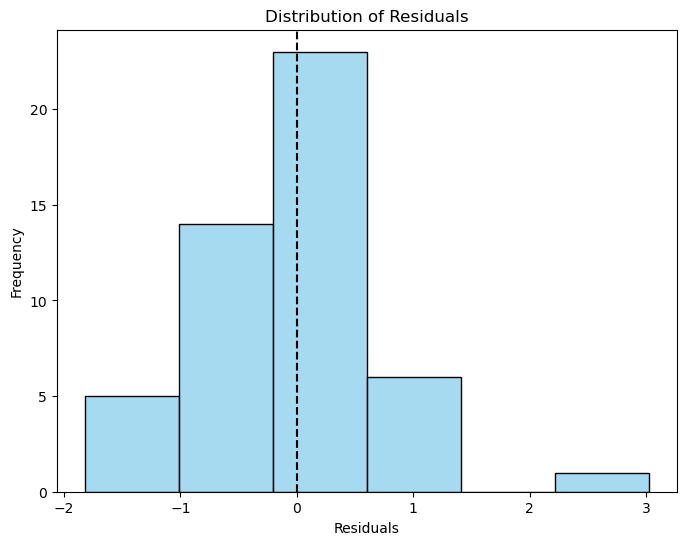

In [450]:
# Calculating residuals
residuals = y_pred - y
plt.figure(figsize=(8,6))
plt.figure(figsize=(8,6))

# Histogram of residuals
sns.histplot(residuals, bins=6, color='skyblue')

plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.axvline(x=0, color='black', linestyle='--')
plt.show()

In [451]:
stat, p = shapiro(residuals)
if p > 0.05:
    print("===============================\n !!Might be normal according to Shapiro-Wilk test!!\n===============================\n")
else:
    print('===============================\n !!Probably NOT normal according to Shapiro-Wilk test!!\n===============================\n')


 !!Probably NOT normal according to Shapiro-Wilk test!!



In [452]:
print(PopVsAcc.summary())

                            OLS Regression Results                            
Dep. Variable:            log Acc tot   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     171.6
Date:                Sat, 21 Jun 2025   Prob (F-statistic):           2.66e-17
Time:                        18:00:14   Log-Likelihood:                -58.846
No. Observations:                  49   AIC:                             121.7
Df Residuals:                      47   BIC:                             125.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  -12.4474 

# Removing the outlier
We can see in the scatter plot that the y-value of the outlier is $\leq$ 6. 

In [418]:
outlier_states = Acc_and_pop_counts.loc[y[y <= 6].index, 'State']
print(f"The state associated with the outlier is {outlier_states.iloc[0]}")

The state associated with the outlier is SD


### Outlier removed
The following presents the regression analysis after we remove the outlier

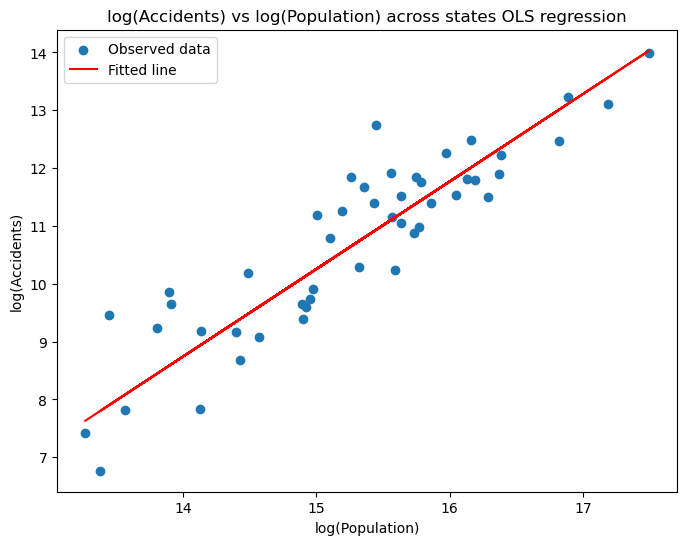

<Figure size 800x600 with 0 Axes>

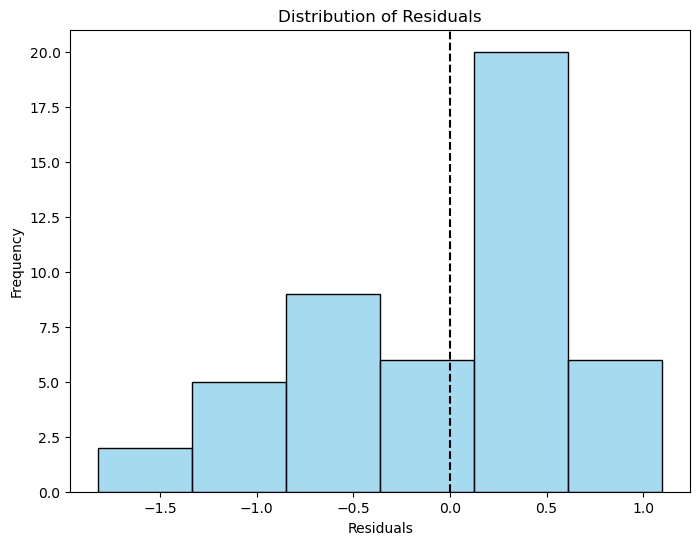

 !!Might be normal according to Shapiro-Wilk test!!

                            OLS Regression Results                            
Dep. Variable:            log Acc tot   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     202.3
Date:                Sat, 21 Jun 2025   Prob (F-statistic):           1.86e-18
Time:                        18:00:36   Log-Likelihood:                -49.250
No. Observations:                  48   AIC:                             102.5
Df Residuals:                      46   BIC:                             106.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

In [453]:

#Removing outlier

indx=y[y>6].index
X_rem=X[indx]
y_rem=y[indx]
X_rem_const=sm.add_constant(X_rem)
PopVsAcc_rem=sm.OLS(y_rem,X_rem_const).fit()
y_rem_pred=PopVsAcc.predict(X_rem_const)


plt.figure(figsize=(8,6))
plt.scatter(X_rem,y_rem,label='Observed data')
plt.plot(X_rem,y_rem_pred,color='red',label='Fitted line')
plt.title('log(Accidents) vs log(Population) across states OLS regression')
plt.legend()
plt.xlabel('log(Population)')
plt.ylabel('log(Accidents)')


residuals_rem = y_rem_pred - y_rem
plt.figure(figsize=(8,6))
plt.figure(figsize=(8,6))

# Residuals Histogram 
sns.histplot(residuals_rem, bins=6, color='skyblue')

plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.axvline(x=0, color='black', linestyle='--')
plt.show()

stat, p = shapiro(residuals_rem)
if p > 0.05:
    print("===============================\n !!Might be normal according to Shapiro-Wilk test!!\n===============================\n")
else:
    print('===============================\n !!Probably NOT normal according to Shapiro-Wilk test!!\n===============================\n!!')

print(PopVsAcc_rem.summary())

### Regression Summary: With vs. Without Outlier

We compare two simple linear regression models predicting total accidents from population count across U.S. states:

---

#### Model 1: With All 49 States (including outlier)

- R²: 0.785  Adjusted R²: 0.780  
- Coefficient for Population: 1.5136 (p < 0.001)   
- Residual normality: Rejected (Shapiro–Wilk p-value small; non-normal residuals)  

This model is moderately strong but shows signs of non-normality in residuals, indicating that the regression assumptions may be violated — likely due to the influence of an outlier (South Dakota).

---

#### Model 2: With Outlier Removed (48 states)

- R²: 0.815  Adjusted R²: 0.811  
- Coefficient for Population: 1.4146 (p < 0.001) 
- Residual normality: Not rejected (Shapiro–Wilk p-value high; residuals likely normal)  

Removing the outlier improves the model noticeably:
- Higher R² and adjusted R²
- Residuals appear normally distributed, making inference more reliable

---

### Interpretation

The outlier had a distorting effect on both the estimated relationship and the residual structure. After removing it, the model fit improves significantly, and the key regression assumptions (e.g., residual normality) are better satisfied.


In [266]:
mean_residual = np.mean(residuals_rem)
std_residual = np.std(residuals_rem, ddof=1)  # ddof=1 for sample standard deviation
print(f"Residual's mean is {mean_residual} and the std is {std_residual}")

Residual's mean is -0.06300382733488308 and the std is 0.6895517129303551


## Summary for log(accidents) vs log(population) relationship

Let $A,P$ denote the accident count and the Population count. The above analysis establishes that $$ A(P)\approx e^{-10.87}\cdot P^{1.41}\cdot e^\epsilon,$$
where $\epsilon\sim\text{N}(-0.063,0.689)$



Text(0, 0.5, 'Accidents count')

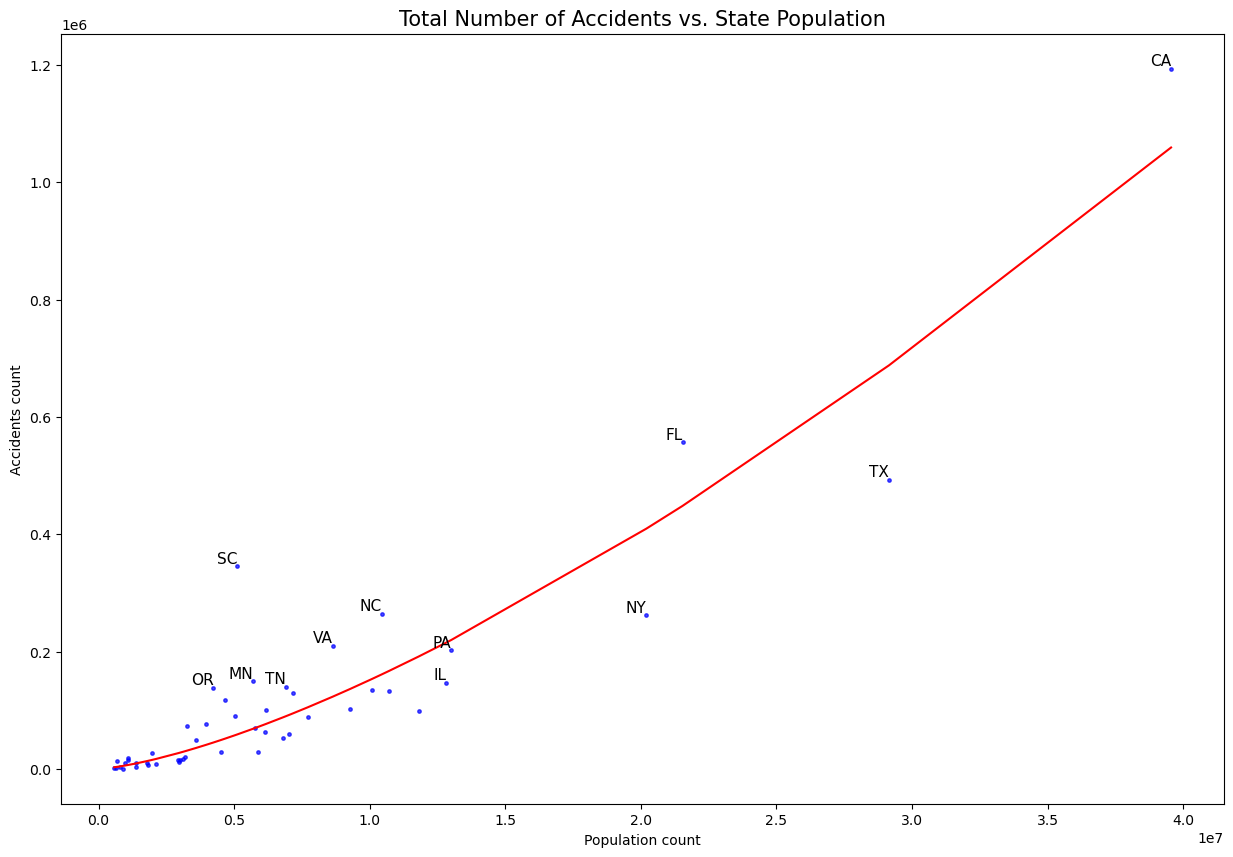

In [305]:
plt.figure(figsize=(15,10))
coeff_array = PopVsAcc_rem.params
a=coeff_array['Population count']
b=coeff_array['const']
x_fit=Acc_and_pop_counts['Population count'].copy().sort_values()
y_fit=(np.exp(b)*x_fit**a)
plt.plot(x_fit,y_fit,color='red')
plt.scatter(Acc_and_pop_counts['Population count'],Acc_and_pop_counts['Acc tot'],color='blue',alpha=0.7,s=6)
threshold = Acc_and_pop_counts['Acc tot'].quantile(0.75)
for i, row in Acc_and_pop_counts.iterrows():
    if row['Acc tot']>threshold:
        plt.text(row['Population count'], row['Acc tot'], row['State'], fontsize=11, alpha=1,
             ha='right', va='bottom')
plt.title('Total Number of Accidents vs. State Population',size=15)
plt.xlabel('Population count')
plt.ylabel('Accidents count')

# Detour --  **SC is a clear outlier**
The above plot shows that SC is an outlier. This is highlighted by the following scatter plot of accidents per capita vs VMT per capita


Text(0, 0.5, 'Accidents per capita')

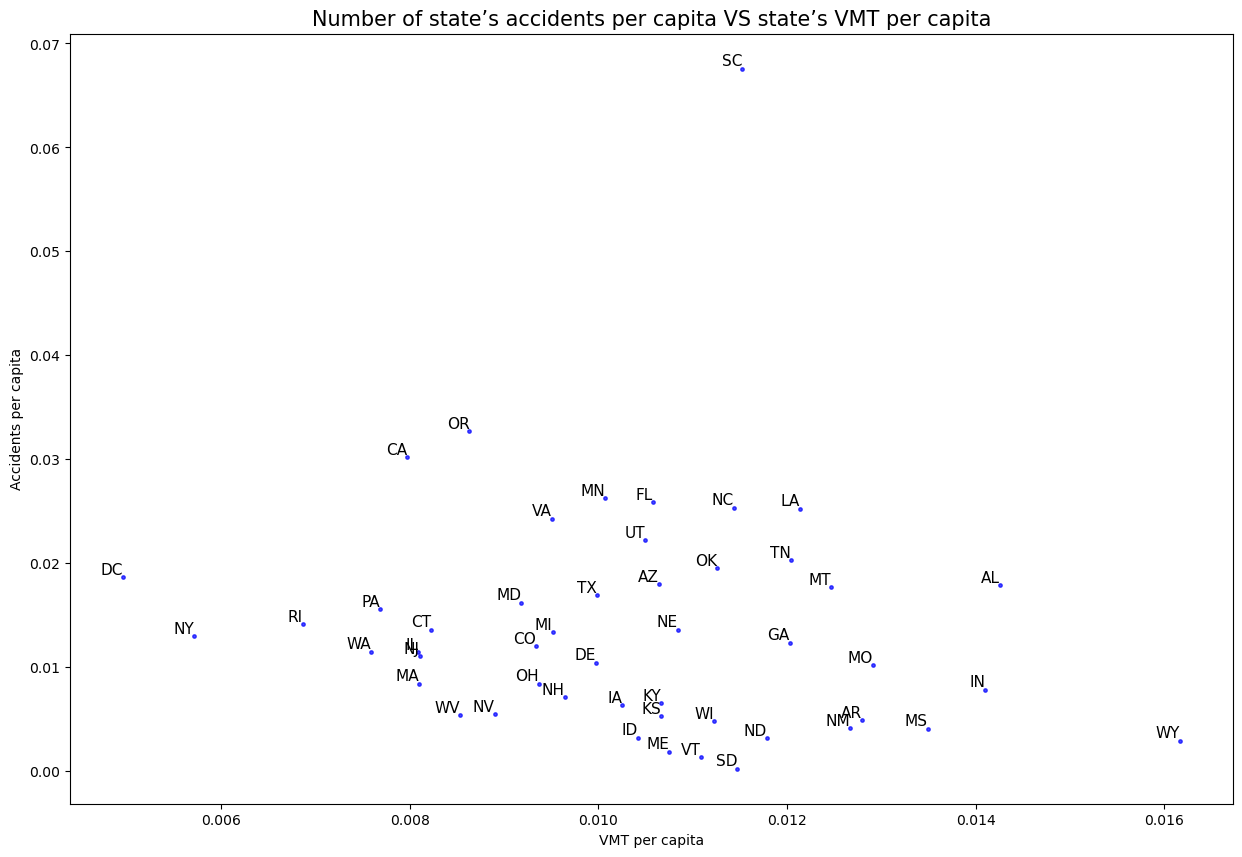

In [158]:
plt.figure(figsize=(15,10))
plt.scatter(Acc_and_pop_counts["VMT per capita"],Acc_and_pop_counts['Acc per capita'],color='blue',alpha=0.7,s=6)
threshold = Acc_and_pop_counts['Acc per capita'].quantile(0.75)
for i, row in Acc_and_pop_counts.iterrows():
    if row['Acc tot']>threshold:
        plt.text(row["VMT per capita"], row['Acc per capita'], row['State'], fontsize=11, alpha=1,
             ha='right', va='bottom')
plt.title('Number of state’s accidents per capita VS state’s VMT per capita',size=15)
plt.xlabel('VMT per capita')
plt.ylabel('Accidents per capita')

**VMT per capita and accidents per capita are not correlated**  -- This is due to the fact the VMT and Population counts have the same growth.

**SC is a clear outlier**. 
Possible explenation: *Compelling evidence for elavated risks in SC*: 
The American Society of Civil Engineers (ASCE) assigned a D grade to South Carolina's road infrastructure in its 2021 Report Card. This assessment highlighted several key concerns:
- Poor Road Conditions: Over 50% of the state's roads were rated in poor condition.
- High Fatality Rate: South Carolina had the highest fatality rate in the U.S., with 1.72 deaths per 100 million vehicle miles traveled.

# linear-regression-logaccidents--logpopulation--vmt-ratio
In the following we add another predictor: $\frac{\text{VMT rural}}{\text{VMT urban}}$ for the accidents count.
We first consider the pair plot of 'log Population count','log Acc tot','VMT rural per urban':

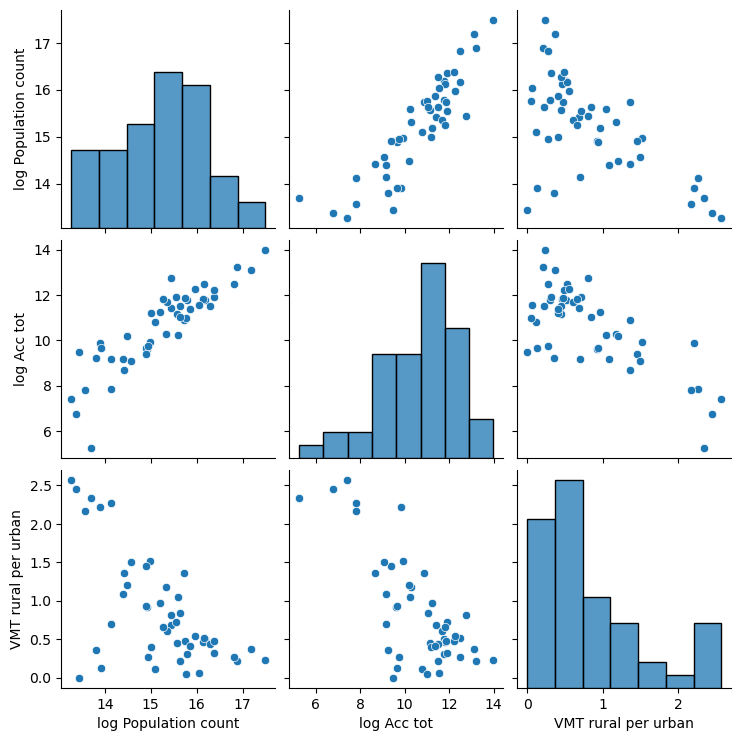

In [422]:
Acc_and_pop_counts.columns
sns.pairplot(Acc_and_pop_counts[['log Population count','log Acc tot','VMT rural per urban']])

- The scatter plot suggests that there is **no strong collinearity** between `log(Population)` and the ratio $\frac{\text{VMT rural}}{\text{VMT urban}}$. This supports their joint use as predictors in a regression model for `log(Accident count)`. This conclusion will be further supported by the **Variance Inflation Factor (VIF)** analysis that follows.

- Interestingly, the plot also reveals a **negative correlation** between `log(Accident count)` and $\frac{\text{VMT rural}}{\text{VMT urban}}$:  
  States with a **higher proportion of rural driving** tend to experience **fewer accidents**, suggesting that urban driving environments may carry higher accident risk.


### Checking co-linearity of log(Population) and  $\frac{\text{VMT rural}}{\text{VMT urban}}$
#### Variance Inflation Factor (VIF)

The Variance Inflation Factor (VIF) is a measure used to detect **multicollinearity** among predictor variables in a regression model.

For each predictor, VIF is calculated as:


$$\text{VIF}_j = \frac{1}{1 - R_j^2}$$


Where $R_j^2$  is the R² from regressing predictor  $j$ on all the other predictors

A **VIF value close to 1** indicates **low multicollinearity**, while values above 5 may suggest a problem.


In [423]:
from statsmodels.stats.outliers_influence import variance_inflation_factor


# Example: assuming X is your dataframe of predictors with constant
X = sm.add_constant(Acc_and_pop_counts[['Population count', 'VMT rural per urban']])

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                   for i in range(X.shape[1])]

print(vif_data)

               feature       VIF
0                const  5.106210
1     Population count  1.239244
2  VMT rural per urban  1.239244


In our case:

- `Population count`: VIF ≈ 1.24  
- `VMT rural per urban`: VIF ≈ 1.24  
- `const` (intercept): VIF ≈ 5.1 (typically not interpreted, it's just a baseline or offset term — not something you interpret in terms of linear relationships with other predictors.)

These results confirm that there is **no concerning multicollinearity** between the predictors.


## Multilinear regression
For consistency, we will keep excluding South Dacota from our data.

In [430]:
X=Acc_and_pop_counts[Acc_and_pop_counts['State']!='SD'][['log Population count','VMT rural per urban']]
y=Acc_and_pop_counts[Acc_and_pop_counts['State']!='SD']['log Acc tot']
X_const=sm.add_constant(X)
MultiModel=sm.OLS(y,X_const).fit()
y_pred=MultiModel.predict(X_const)

print(MultiModel.summary())

                            OLS Regression Results                            
Dep. Variable:            log Acc tot   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     136.4
Date:                Sat, 21 Jun 2025   Prob (F-statistic):           7.91e-20
Time:                        17:36:27   Log-Likelihood:                -42.796
No. Observations:                  48   AIC:                             91.59
Df Residuals:                      45   BIC:                             97.21
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -6.6434 

Residual's mean is -0.06 and the std is 0.69
 !!Might be normal according to Shapiro-Wilk test!!



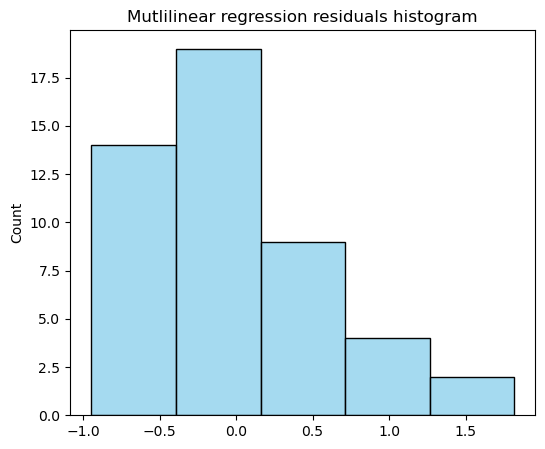

In [445]:
residuals_mult= y - y_pred

mean_residual_mult = np.mean(residuals_mult)
std_residual_mult = np.std(residuals_mult, ddof=1)  # ddof=1 for sample standard deviation
print(f"Residual's mean is {mean_residual:.2f} and the std is {std_residual:.2f}")
plt.figure(figsize=(6,5))
sns.histplot(residuals_mult,bins=5,color='skyblue')
plt.title('Mutlilinear regression residuals histogram')
stat, p = shapiro(residuals_rem)
if p > 0.05:
    print("===============================\n !!Might be normal according to Shapiro-Wilk test!!\n===============================\n")
else:
    print('===============================\n !!Probably NOT normal according to Shapiro-Wilk test!!\n===============================\n!!')


#### Model summary
Let $A,P,V$ denote Accident count, Population count and VMT rural per urban. Then the above model predicts:
$$A(P,V)=e^{-6.64} P^{1.17} e^{-0.62V} e^{\epsilon},$$
where $\epsilon \sim \text{N}(-0.06,0,69)$.

### Comparison of Log-Log Regression Models

We compare two log-log linear regression models for predicting accident counts across U.S. states, using population and driving environment data. Both models exclude the identified outlier (South Dakota). In both cases, the Shapiro-Wilk test did not reject residual normality, indicating that model assumptions are reasonably satisfied.

---

#### Model 1: Log-Log Regression with Population Only

- **Dependent variable**: `log(Acc tot)`  
- **Predictor**: `log(Population count)`  
- **R²**: 0.815  **Adjusted R²**: 0.811  
- **p-value (log Population)**: < 0.001  
- **Residual normality**: Not rejected

This model captures a strong, positive, and statistically significant relationship between population size and accident counts on a log scale, suggesting near power-law scaling.

---

#### Model 2: Log-Log Regression with Population and VMT Ratio

- **Dependent variable**: `log(Acc tot)`  
- **Predictors**: `log(Population count)`, `VMT rural per urban`  
- **R²**: 0.858  **Adjusted R²**: 0.852   
- **p-value (log Population)**: < 0.001  
- **p-value (VMT ratio)**: 0.001  
- **Residual normality**: Not rejected

Adding the `VMT rural per urban` ratio improves model fit:
- Higher R² and lower AIC indicate greater explanatory power.
- The negative coefficient on the VMT ratio suggests that states with more rural driving relative to urban driving tend to have fewer accidents, after accounting for population.

---

### Conclusion

Both models support a log-log relationship between population and accident counts. However, Model 2 offers a better statistical fit and incorporates an important second predictor (VMT ratio), capturing variation due to driving environment.


# summary-and-interpretation

This analysis demonstrated that population size alone explains a large portion of the variance in state-level traffic accident counts (adjusted R² ≈ 0.81). 

By introducing a second, interpretable feature — the ratio of rural to urban vehicle miles traveled (VMT) — the model's performance improved further (adjusted R² ≈ 0.85). 

This suggests that population is a powerful baseline predictor, and that geographic driving patterns provide meaningful refinement. These simple, publicly available variables together offer a surprisingly effective explanation of accident variability across U.S. states.
